<a href="https://colab.research.google.com/github/JayThibs/hyperdrive-vs-automl-plus-deployment/blob/main/Tanzania_Competition_Udacity_AzureML_Capstone_Colab_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [32]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

In [33]:
del y_train['id']

In [34]:
df = pd.concat([X_train, y_train], axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


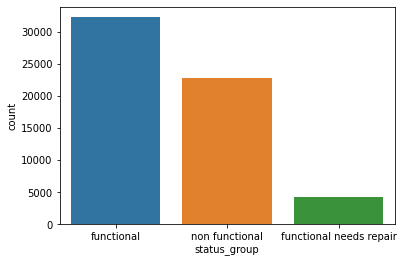

In [35]:
sns.countplot(df['status_group'])

In [36]:
# Percentage of each class
df['status_group'].value_counts(normalize = True) * 100

functional                 54.308081
non functional             38.424242
functional needs repair     7.267677
Name: status_group, dtype: float64

In [37]:
# Looking at statistics from the training data
# The mean for construction year is definitely off. Looks like there might 
# be a lot of 0 values if we look at the min and 25% rows.
# We can see the same issue for some of the other columns.
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [38]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [39]:
# Let's add some date related columns with fastai's `add_datepart`
# df = add_datepart(df, 'date_recorded')

In [40]:
# We can see the extra columns are added
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [41]:
# Let's check to see if any of the categorical columns follow an order (e.g. from low to high)
# Spoiler alert: they don't
df['quality_group'].unique()

array(['good', 'salty', 'milky', 'unknown', 'fluoride', 'colored'],
      dtype=object)

In [42]:
df['quantity'].unique()

array(['enough', 'insufficient', 'dry', 'seasonal', 'unknown'],
      dtype=object)

In [43]:
# Number of unique values per column
# For categorical values, this is the number of classes
print('Total number of examples: ' + str(len(df)))
df.nunique().sort_values()

Total number of examples: 59400


recorded_by                  1
public_meeting               2
permit                       2
status_group                 3
source_class                 3
quantity_group               5
quantity                     5
management_group             5
quality_group                6
waterpoint_type_group        6
payment                      7
extraction_type_class        7
waterpoint_type              7
source_type                  7
payment_type                 7
water_quality                8
basin                        9
source                      10
management                  12
scheme_management           12
extraction_type_group       13
extraction_type             18
district_code               20
region                      21
region_code                 27
construction_year           55
num_private                 65
amount_tsh                  98
lga                        125
date_recorded              356
population                1049
funder                    1897
ward    

In [44]:
# Let's check the number of null values for construction_year
len(df[df.construction_year == 0])

20709

In [45]:
# A lot of null values for construction year. Of course, this is a missing value (a placeholder).
# For modeling purposes, this is actually fine, but we'll have trouble with visualizations if we
# compare the results for different years, so we'll set the value to something closer to
# the other values that aren't placeholders. Let's look at the unique years and set the null
# values to 50 years sooner.
pd.Series(df['construction_year'].unique()).sort_values()[0:10]

4        0
38    1960
39    1961
24    1962
41    1963
52    1964
54    1965
53    1966
48    1967
44    1968
dtype: int64

In [46]:
# Alright, let's set it to 1910
df.loc[df['construction_year'] < 1950, 'construction_year'] = 1910

In [47]:
# Let's check to make sure
pd.Series(df['construction_year'].unique()).sort_values()[0:10]

4     1910
38    1960
39    1961
24    1962
41    1963
52    1964
54    1965
53    1966
48    1967
44    1968
dtype: int64

In [48]:
# Now, let's do some more general preprocessing to handle strings and missing data.
# We'll be using two fastai classes: TabularProc and TabularPandas
# TabularProc does preprocessing for TabularPandas. We'll use Categorify to replace
# columns with floats or integers with a numeric categorical column.
# FillMissing replaces missing values with the median of the column, and
# creates a new Boolean column that is set to True for any row where the value is missing.
# procs = [Categorify, FillMissing]

In [49]:
# Before we use TabularPandas, we need to tell it which columns are continuous and which are categorical
# We can do this with the helper function `cont_cat_split`
# cont, cat = cont_cat_split(df, 1, dep_var='status_group')

In [50]:
# to = TabularPandas(df, procs, cat, cont)

In [51]:
# to.show(3)

In [52]:
# clean_X = to.train.xs
# clean_y = to.

In [53]:
# clean_y 

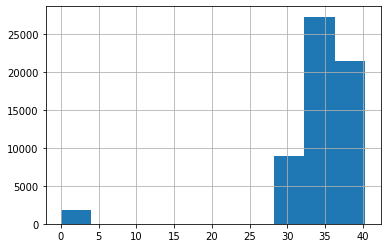

In [54]:
df['longitude'].hist()

In [55]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,1910,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [56]:
def bools(df):
    """
    public_meeting: we will fill the nulls as 'False'
    permit: we will fill the nulls as 'False
    """
    z = ['public_meeting', 'permit']
    for i in z:
        df[i].fillna(False, inplace = True)
        df[i] = df[i].apply(lambda x: float(x))
    return df

def locs(df):
    """
    fill in the nulls for ['longitude', 'latitude', 'gps_height', 'population'] by using medians from 
    ['subvillage', 'district_code', 'basin'], and lastly the overall median
    """
    trans = ['longitude', 'latitude', 'gps_height', 'population']
    df.loc[df.longitude == 0, 'latitude'] = 0
    for z in trans:
        df[z].replace(0., np.NaN, inplace = True)
        df[z].replace(1., np.NaN, inplace = True)
        
        for j in ['district_code', 'basin']:
        
            df['median'] = df.groupby([j])[z].transform('median')
            df[z] = df[z].fillna(df['median'])
        
        df[z] = df[z].fillna(df[z].median())
        del df['median']
    return df

def construction(df):
    """
    construction_year has 35% nulls, so we impute the nulls with the column median
    """
    df['construction_year'].replace(0, df[df['construction_year'] != 0]['construction_year'].median(), inplace=True)
    return df

df = bools(df)
df = locs(df)
df = construction(df)

In [59]:
# Alright, now let's drop a few columns

def removal(df):
  # id: we drop the id column because it is not a useful predictor.
  # amount_tsh: is mostly blank - delete
  # wpt_name: not useful, delete (too many values)
  # subvillage: too many values, delete
  # scheme_name: this is almost 50% nulls, so we will delete this column
  # num_private: we will delete this column because ~99% of the values are zeros.
  features_to_drop = ['id','amount_tsh',  'num_private', 
          'quantity', 'quality_group', 'source_type', 'payment', 
          'waterpoint_type_group', 'extraction_type_group', 'wpt_name', 
          'subvillage', 'scheme_name']
  df = df.drop(features_to_drop, axis=1)

  return df
  
df = removal(df)

In [61]:
dummy_cols = ['funder', 'installer', 'basin', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity_group', 'source',
       'source_class', 'waterpoint_type', 'region']

In [62]:
df = pd.get_dummies(df, columns=dummy_cols)

In [63]:
def dates(df):
    """
    date_recorded: this might be a useful variable for this analysis, although the year itself would be useless in a practical scenario moving into the future. We will convert this column into a datetime, and we will also create 'year_recorded' and 'month_recorded' columns just in case those levels prove to be useful. A visual inspection of both casts significant doubt on that possibility, but we'll proceed for now. We will delete date_recorded itself, since random forest cannot accept datetime
    """
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['year_recorded'] = df['date_recorded'].apply(lambda x: x.year)
    df['month_recorded'] = df['date_recorded'].apply(lambda x: x.month)
    df['date_recorded'] = (pd.to_datetime(df['date_recorded'])).apply(lambda x: x.toordinal())
    return df

def dates2(df):
    """
    Turn year_recorded and month_recorded into dummy variables
    """
    for z in ['month_recorded', 'year_recorded']:
        df[z] = df[z].apply(lambda x: str(x))
        good_cols = [z+'_'+i for i in df[z].unique()]
        df = pd.concat((df, pd.get_dummies(df[z], prefix = z)[good_cols]), axis = 1)
        del df[z]
    return df

In [64]:
df = dates(df)
df = dates2(df)

In [65]:
df.head()

,date_recorded,gps_height,longitude,latitude,region_code,district_code,population,construction_year,status_group,funder_0,funder_A/co Germany,funder_Aar,funder_Abas Ka,funder_Abasia,funder_Abc-ihushi Development Cent,funder_Abd,funder_Abdala,funder_Abddwe,funder_Abdul,funder_Abood,funder_Abs,funder_Aco/germany,funder_Acord,funder_Acord Ngo,funder_Acra,funder_Act,funder_Act Mara,funder_Action Aid,funder_Action Contre La Faim,funder_Action In A,funder_Adap,funder_Adb,funder_Adf,funder_Adp,funder_Adp Bungu,funder_Adp Mombo,funder_Adp/w,funder_Adra,funder_Af,funder_Afdp,...,waterpoint_type_improved spring,waterpoint_type_other,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,month_recorded_3,month_recorded_2,month_recorded_1,month_recorded_7,month_recorded_10,month_recorded_11,month_recorded_8,month_recorded_9,month_recorded_4,month_recorded_5,month_recorded_6,month_recorded_12,year_recorded_2011,year_recorded_2013,year_recorded_2012,year_recorded_2004,year_recorded_2002
0,734210,1390.0,34.938093,-9.856322,11,5,109.0,1999,functional,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,734933,1399.0,34.698766,-2.147466,20,2,280.0,2010,functional,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,734924,686.0,37.460664,-3.821329,21,4,250.0,2009,functional,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,734896,263.0,38.486161,-11.155298,90,63,58.0,1986,non functional,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,734331,1181.0,31.130847,-1.825359,18,1,250.0,1910,functional,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [66]:
y_train = df['status_group']
del df['status_group']
X_train = df

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [72]:
len(X_train), len(y_train), len(X_test), len(y_test)

(47520, 47520, 11880, 11880)

In [73]:
rf = RandomForestClassifier(criterion='gini',
                                min_samples_split=6,
                                n_estimators=1000,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [74]:
rf.oob_score_

0.8111111111111111

In [75]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
           axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
2,longitude,0.064089
3,latitude,0.063923
6350,quantity_group_dry,0.054274
1,gps_height,0.038880
0,date_recorded,0.036092
7,construction_year,0.029668
6351,quantity_group_enough,0.028973
6,population,0.026770
6374,waterpoint_type_other,0.021944
6314,extraction_type_class_other,0.017672


In [76]:
y_test

2980     non functional
5246         functional
22659        functional
39888    non functional
13361        functional
              ...      
17841        functional
20222        functional
40219    non functional
19599        functional
41264        functional
Name: status_group, Length: 11880, dtype: object

In [77]:
predictions = rf.predict(X_test)
pred = pd.DataFrame(predictions)

In [78]:
pred

,0
0,non functional
1,non functional
2,functional
3,non functional
4,functional
...,...
11875,functional
11876,functional
11877,non functional
11878,functional


In [80]:
from sklearn.metrics import recall_score

# calculate recall
recall = recall_score(y_test, pred, average='micro')
print('Recall: %.3f' % recall)

Recall: 0.812


In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_predictions = xgb.predict(X_val)
xgb_preds = pd.DataFrame(xgb_predictions, columns = [y_val.columns[0]])

In [ ]:
from sklearn.metrics import recall_score

# calculate recall
recall = recall_score(y_val, xgb_preds, average='micro')
print('Recall: %.3f' % recall)

Recall: 0.745
